To improve prediction, I use the features in the same module for splitting variables and use principal components (maybe incorporate time??) for regressors!

In [1]:
library("party")
library(MASS)
library("glmertree")
library("caret")
source("SimData.r")
library("randomForest")
library("rpart")
library("fuzzyforest")
library("WGCNA")

Warning message:
"package 'party' was built under R version 3.6.1"Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Warning message:
"package 'strucchange' was built under R version 3.6.1"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
Warning message:
"package 'sandwich' was built under R version 3.6.1"Warning message:
"package 'glmertree' was built under R version 3.6.1"Loading required package: lme4
Warning message:
"package 'lme4' was built under R version 3.6.1"Loading required package: Matrix

Attaching package: 'lme4'

The following object is masked from 'package:modeltools':

    refit

Loading required package: partykit
Warning message:
"package 'partykit' was built under R version 3.6.1"Loading required package: libcoin
Warning 

# Data

In [2]:
# training data
n <- 100 # number of patients
T <-  5 # number of observations per patients

set.seed(100)

data <- as.data.frame(sim_3(n, T)) 
colnames(data)[401] <- "y"


# add patient/cluster information
for (i in 1:n){
    data$patient[(1+(i-1)*T):(i*T)] = rep(i,T)
}

# add first PC for each module
data_mat = data[,1:400]
data$PC1 = svd(data_mat[,1:100])$u[,1] 
data$PC2 = svd(data_mat[,101:200])$u[,1] 
data$PC3 = svd(data_mat[,201:300])$u[,1]  
data$PC4 = svd(data_mat[,301:400])$u[,1] 


data[1:6,]

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V397,V398,V399,V400,y,patient,PC1,PC2,PC3,PC4
0.4041948,-0.1157621,-0.8282505,-0.2551767,0.7114005,0.09327738,0.4703178,-0.5625359,0.71595493,0.1898496,...,-0.5817907,0.31863009,0.1169713,0.88678481,-2.680183,1,-0.003542393,-0.0053983048,-0.021006464,-0.04368350
-0.5048507,-1.1607588,-0.9535845,-1.1433429,-0.3331617,-1.11665992,-0.4615737,-1.5207829,0.02850286,-0.3527653,...,-1.6737887,0.91176834,-0.5207258,0.08539332,-11.353485,1,0.036431670,-0.0008289507,-0.048923709,-0.01565303
-0.8002010,-0.8082677,-1.0642596,-1.0390025,-0.5794711,-0.98738083,-0.5376431,-1.4163408,-0.22285559,-0.4874867,...,-2.4876058,0.85579524,0.1344519,-0.31106741,-9.402297,1,0.036749693,-0.0466865136,-0.046991087,-0.02350035
-0.9136394,-1.3453939,-1.2412924,-0.5843280,-0.7852858,-1.10955238,-1.0380377,-1.3915048,-0.74088698,-0.3579343,...,-3.0802759,0.76572763,-0.3152833,0.01155116,-2.714342,1,0.045986423,-0.0245292453,0.003867004,-0.02910438
-1.1862461,-0.8985310,-1.1362628,-0.5670641,-0.4920586,-0.39728046,-0.6302260,-0.6027598,-0.23438185,-0.3974606,...,-2.9496439,0.05246792,-0.7299419,-0.76754000,-8.588217,1,0.032324774,-0.0163962064,0.012075129,-0.01523007
0.7559472,2.1693698,1.1034058,1.9401066,0.6839483,1.12735727,1.5714702,1.5045449,1.51050327,1.6902715,...,0.2431390,-1.33757722,-0.2405078,-0.62730903,20.835334,2,-0.078646804,0.0094518451,0.056310078,-0.04234840


In [3]:
# test data
n <- 30 # number of patients; OVERWRITE! n=30 now! 
T <-  5 # number of observations per patients
set.seed(101)
data_test <- as.data.frame(sim_3(n, T)) 
colnames(data_test)[401] <- "y"


# add patient/cluster information
for (i in 1:n){
    data_test$patient[(1+(i-1)*T):(i*T)] = rep(i,T)
}
# add PC
data_mat = data_test[,1:400]
data_test$PC1 = svd(data_mat[,1:100])$u[,1]  
data_test$PC2 = svd(data_mat[,101:200])$u[,1] 
data_test$PC3 = svd(data_mat[,201:300])$u[,1] 
data_test$PC4 = svd(data_mat[,301:400])$u[,1] 


data_test[1:6,]

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V397,V398,V399,V400,y,patient,PC1,PC2,PC3,PC4
0.2060153,0.64024620,0.34032334,1.05586322,1.5860748,0.8222607,0.3228772,1.9814633,0.1915002,0.1206337,...,0.61878986,1.1739663,0.3107692,0.21435946,11.569677,1,-0.070461165,-0.04842728,0.02893682,-0.007330753
1.0581125,1.83637294,1.28134711,1.95099335,2.1117273,1.5162299,1.1903985,2.6089574,1.1034408,0.7703308,...,-0.32767601,0.4441376,0.3337583,0.43528673,31.206793,1,-0.170295516,0.07283701,0.04054332,-0.020246396
0.4365846,1.46430543,0.75723534,1.59393501,1.4047144,0.6625449,0.5281878,1.8311688,0.8361954,0.9370753,...,0.16902591,0.9010316,0.1224454,0.57227788,15.835104,1,-0.117995465,0.04209900,0.10973472,-0.004050225
0.3370362,1.27335072,0.85899400,1.14445890,1.0956487,0.4145852,0.3415175,1.8317050,0.4938670,1.2542567,...,0.03718500,1.0193002,0.2050546,0.07434591,12.294316,1,-0.094719831,0.06103178,0.02542602,0.056658361
-1.0935606,-0.04208021,-0.06375357,-0.02680852,-0.2886002,-0.6175841,-0.8728703,0.5218694,-0.7432135,0.2455381,...,0.09446398,0.4766140,-1.2353549,-0.25145304,-9.295610,1,0.031775643,0.10847850,0.06866233,0.099423157
0.2791273,0.75162924,-0.30528207,-0.21112131,-0.2949749,-0.2916753,0.1386101,0.7237688,0.8251524,0.4313684,...,2.28742993,0.6374255,0.4740288,1.31109763,7.697065,2,-0.003065868,0.03813581,-0.10388196,-0.123825548


In [4]:
# Methods for extracting names of splitting features used in a tree
# tree: a tree object; data: the train or test set
# here tree should be lm_tree$tree
get_split_names = function(tree,data){
    paths <- pre:::list.rules(tree, removecomplements = FALSE)
    vnames <- names(data)
    return(vnames[sapply(sapply(vnames, FUN = function(x) grep(x, paths)), length) > 0])
}

# Gtree

In [11]:
# regress_var = paste("PC",c(3),sep="")
# regress_var = paste("PC",c(1,2,3),sep="")
# regress_var = paste("V",c(1,2,3,301,302,303),sep="") # abs correct regressor
# regress_var = paste("V",c(1,301,65,305,9,100,101),sep="") # disturbation
regress_var = paste("V",c(1,2,3,301,302,303,5,185),sep="") # abs correct regressor
# regress_var = paste("V",301:400,sep="") # abs correct regressor


# split_var = paste("V",201:300,sep="") # always use all the features to split
split_var = paste("V",c(1,2,3,301,302,303,5,185),sep="") # abs correct regressor
# split_var = paste("V",c(3,2),sep="")

cluster_var = "patient"
Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                         paste(split_var,collapse = "+")))
# mob_control_ = mob_control(maxdepth = 5)

   user  system elapsed 
   0.84    0.00    1.03 

[1] 11.94552

[1] "V3"   "V30"  "V303"

,(Intercept),V1,V2,V3,V301,V302,V303,V5,V185
3,-0.6569926,4.160225,-0.6952360,-2.111626,5.673148,-1.545612,1.959435,0.1108023,0.0927394
4,-0.5089608,5.726403,-0.6962838,-2.743484,4.418012,6.670330,1.272826,0.7110351,0.5557941
6,-4.6185567,4.767361,4.6555828,10.862575,4.656105,-1.190742,1.622446,-0.5899854,-0.8156271
7,-5.2708310,4.863080,5.7073376,8.934818,4.759928,5.825097,3.070134,0.5969978,0.1222523


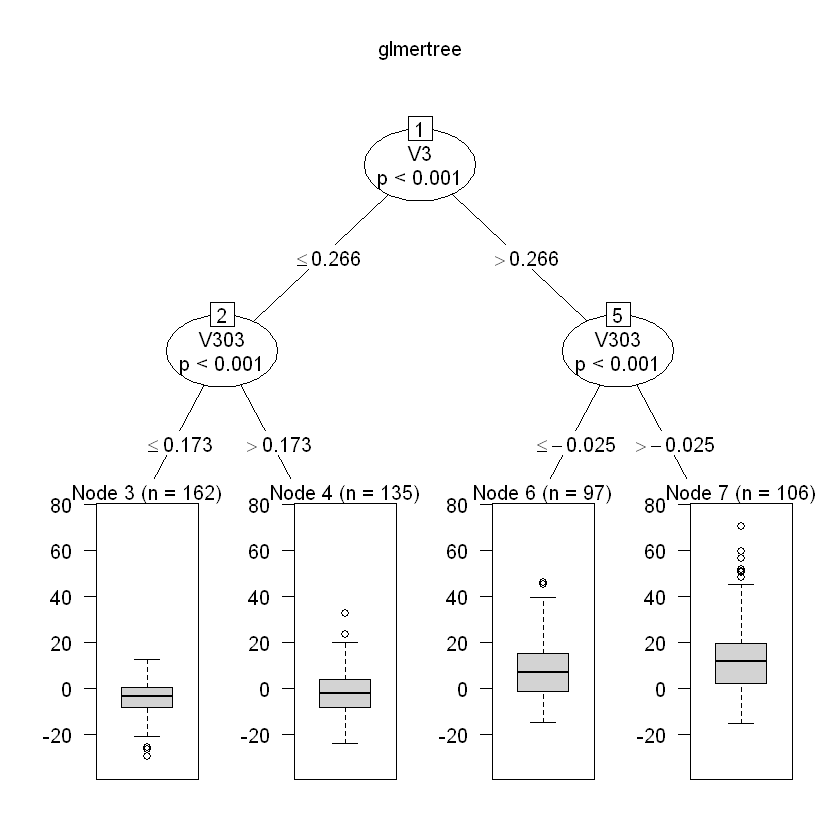

In [12]:
system.time({
    lmm_tree <- lmertree(Formula, data = data,alpha=0.2) # you can change alpha = 0.2
})
# mean square error on test data
sum((predict(lmm_tree,newdata=data_test,re.form=NA)-data_test$y)**2)/(n*T)

# the selected features
get_split_names(lmm_tree$tree,data)

coef(lmm_tree)
plot(lmm_tree,which="tree",main = "glmertree")

# PCA TEST

In [53]:
X = matrix(rep(1,12),3,4)
# X = data.frame(X)
X
A = X%*%t(X)
A

1,1,1,1
1,1,1,1
1,1,1,1


4,4,4
4,4,4
4,4,4


In [54]:
ev <- eigen(A)
ev

eigen() decomposition
$values
[1] 1.200000e+01 3.552714e-15 0.000000e+00

$vectors
           [,1]       [,2]       [,3]
[1,] -0.5773503  0.8164966  0.0000000
[2,] -0.5773503 -0.4082483 -0.7071068
[3,] -0.5773503 -0.4082483  0.7071068


In [58]:
ev$vector[,1] # first PC

[1] -0.5773503 -0.5773503 -0.5773503

In [66]:
svd(X)$u[,1] # or use this directly

[1] -0.5773503 -0.5773503 -0.5773503

In [51]:
# PCA but i don't get it
prcomp(t(X))

Standard deviations (1, .., p=3):
[1] 0 0 0

Rotation (n x k) = (3 x 3):
     PC1 PC2 PC3
[1,]   1   0   0
[2,]   0   1   0
[3,]   0   0   1